# Import libraries

In [1]:
#----------------------------
# import libraries
#----------------------------
import numpy as np
import pandas as pd
import scipy.io as sio
from matplotlib import pyplot as plt
#----------------------------
# scikit-learn
#----------------------------
# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
# svm
from sklearn.svm import SVC
# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import zero_one_loss
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
#use numpy fixed point notation
np.set_printoptions(suppress=True)
#----------------------------
# disable convergence warning
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
#----------------------------
# path to save figures
path = '../figures/svm/'

# Reading the dataset (.mat file)

In [3]:
from os.path import abspath, join
# get the root dir ('current_dir/..')
root_dir = abspath('..')
dataset_dir = join(root_dir, 'dataset')

In [4]:
# set dataset files path
training_file = join(dataset_dir, 'dados_treinamento.mat')
validation_file = join(dataset_dir, 'dados_val.mat')
test_file = join(dataset_dir, 'dados_teste.mat')

In [5]:
# read mat files
training = sio.loadmat(training_file)
validation = sio.loadmat(validation_file)
test = sio.loadmat(test_file)

## Training, validation and test sets

In [6]:
# training set
X_raw = training['X']
y_raw = training['y']
y = y_raw.flatten()
#----------------------------
# validation set
Xval_raw = validation['Xval']
yval_raw = validation['yval']
yval = yval_raw.flatten()
#----------------------------
# test set
Xt_raw = test['Xt']
yt_raw = test['yt']
yt = yt_raw.flatten()

# Preprocessing the data

In [7]:
# data standardization: x' = (x - u) / s
scaler = StandardScaler()
# fit only on training + validation set
scaler.fit(X_raw + Xval_raw)
# perform standardization with x data
X = scaler.transform(X_raw)
Xval = scaler.transform(Xval_raw)
# apply same transformation to test data
Xt = scaler.transform(Xt_raw)

## Adjusting labels to 0 or 1

In [8]:
y = (y + 1) / 2
yval = (yval + 1) / 2
yt = (yt + 1) / 2

# Data Visualization

## Plotting the result of classification

In [9]:
def plot_data(X, y, alpha=1):
    # prepare date
    x1 = X[:,0]
    x2 = X[:,1]
    y = y.flatten()
    # create dataframe
    df = pd.DataFrame(data={'x1': x1, 'x2': x2, 'label': y})
    # dataframe of positive and negative class
    PC = df.loc[df['label'] == 1]
    NC = df.loc[df['label'] == 0]
    # plot points
    #plt.cla() # clear axis
    #plt.clf() # clear figure
    #ax = PC.plot(kind='scatter', x='x1', y='x2', color='blue', marker='.')
    #NC.plot(ax=ax, grid=True, kind='scatter', x='x1', y='x2', color='red', marker='.')
    ax1 = PC.plot(kind='scatter', x='x1', y='x2', alpha=alpha, color='blue', marker='.')
    ax2 = NC.plot(ax=ax1, grid=True, kind='scatter', x='x1', y='x2', alpha=alpha, color='red', marker='.')
    return ax2

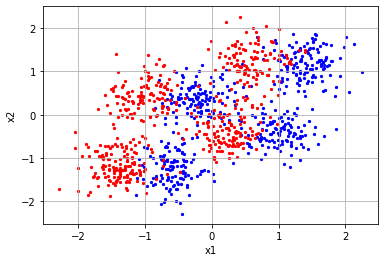

In [10]:
plot_data(X_raw, y)

## Plotting the decision regions

In [11]:
def plot_decision_regions(X, model):
    # split X in x1 andlab x2
    x1 = X[:, 0]
    x2 = X[:, 1]
    # define grid limits for x1 and x2
    x1_min = x1.min() - 0.25
    x1_max = x1.max() + 0.25
    x2_min = x2.min() - 0.25
    x2_max = x2.max() + 0.25
    #----------------------------
    # create grid
    #steps = 4096
    step = 0.01
    #x1_span = np.linspace(x1_min, x1_max, steps)
    #x2_span = np.linspace(x2_min, x2_max, steps)
    #xx1, xx2 = np.meshgrid(x1_span, x2_span)
    x1_span = np.arange(x1_min, x1_max, step)
    x2_span = np.arange(x2_min, x2_max, step)
    xx1, xx2 = np.meshgrid(x1_span, x2_span)
    # convert to 1-D array and concatenate them
    xx1_f = xx1.flatten()
    xx2_f = xx2.flatten()
    points = np.c_[xx1_f, xx2_f]
    #----------------------------
    # plot decision regions
    y = model.predict(points)
    y = y.reshape(xx1.shape)
    ax = plt.contourf(xx1, xx2, y, cmap=plt.cm.Spectral)
    return ax

## Draw a circle around the support vectors

In [12]:
def circle_sv(X, y, model):
    sv_t = model.support_vectors_
    sv = scaler.inverse_transform(sv_t)
    ax = plot_data(X, y, alpha=0.3)
    for i in sv_t:
        circle = plt.Circle(i, 0.05, color='black', fill=False, alpha=0.5)
        ax.add_artist(circle)
    return ax

## Find support vectors

In [13]:
def find_sv(X, y, model):
    sv_t = model.support_vectors_
    sv = scaler.inverse_transform(sv_t)
    ax = plot_data(X, y, alpha=0.5)
    plt.scatter(sv_t[:,0], sv_t[:,1], marker='.', color='black', alpha=1)
    return ax

# Support Vector Machine

## RBF kernel

In [14]:
rbf_svc = SVC(
    C = 1,
    kernel='rbf',
    gamma = 'scale',
    tol = 1e-4,
    #random_state = 42,
    #verbose=True,
)

## Linear kernel

In [15]:
linear_svc = SVC(
    C = 1,
    kernel='linear',
    gamma = 'scale',
    tol = 1e-4,
    #random_state = 42,
    #verbose=True,
)

## Polynomial kernel

In [16]:
poly_svc = SVC(
    C = 1,
    kernel='poly',
    gamma = 'scale',
    tol = 1e-4,
    #random_state = 42,
    #verbose=True,
)

## Sigmoid kernel

In [17]:
sigmoid_svc = SVC(
    C = 1,
    kernel='sigmoid',
    gamma = 'scale',
    tol = 1e-4,
    #random_state = 42,
    #verbose=True,
)

# Finding hyperparameter C with cross-validation

In [18]:
def find_C(X, y, Xval, yval, model):
    # initialization
    parameters = model.get_params()
    values = np.linspace(0.1, 10, 100)
    best_C = 0.1
    best_score = 0
    # start sweeping C
    for C in values:
        parameters['C'] = C
        svm = SVC(**parameters)
        svm.fit(X, y)
        # cross-validation
        score = svm.score(Xval, yval)
        if (score > best_score):
            best_score = score
            best_C = C
    return best_C

In [19]:
best_C = find_C(X, y, Xval, yval, rbf_svc)
print('\'C\' optimum =', best_C)

'C' optimum = 8.3


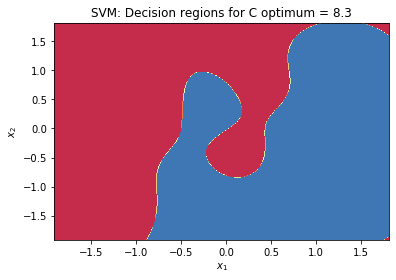

In [20]:
# adjust parameters
parameters = rbf_svc.get_params()
parameters['C'] = best_C
svm = SVC(**parameters)
#----------------------------
# joint training and validation sets
training_X = np.append(X, Xval, axis=0)
training_y = np.append(y, yval, axis=0)
#----------------------------
# fit model
svm.fit(training_X, training_y)
plot_decision_regions(X, svm)
plt.title('SVM: Decision regions for C optimum = 8.3')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig(path + 'svm_decision_region.png', dpi=300)

# Showing support vectors

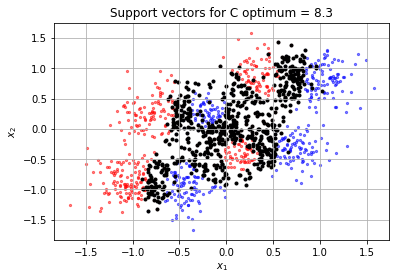

In [21]:
find_sv(X, y, svm)
plt.title('Support vectors for C optimum = 8.3')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig(path + 'support_vectors.png', dpi=300)

# Score in test set

In [22]:
print('Score =', svm.score(Xt, yt))

Score = 0.877


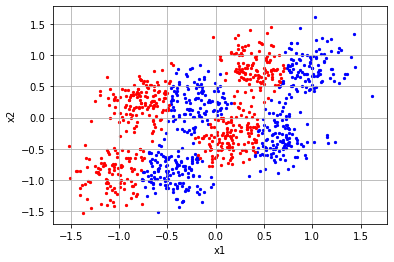

In [23]:
plot_data(Xt, svm.predict(Xt))
plt.savefig(path + 'svm_test_set_output.png', dpi=300)

# Exploring different values of C

## C = 0.1

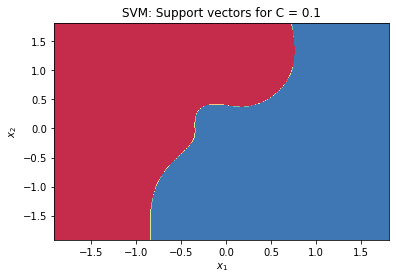

In [24]:
# adjust parameters
parameters = rbf_svc.get_params()
parameters['C'] = 0.1
svm = SVC(**parameters)
#----------------------------
# fit model
svm.fit(training_X, training_y)
plot_decision_regions(X, svm)
plt.title('SVM: Support vectors for C = 0.1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig(path + 'decision_region_C_0d1.png', dpi=300)

In [25]:
print('Score =', svm.score(Xt, yt))

Score = 0.761


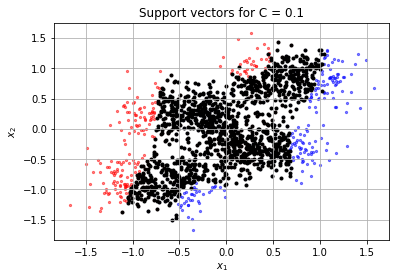

In [26]:
find_sv(X, y, svm)
plt.title('Support vectors for C = 0.1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig(path + 'support_vectors_C_0d1.png', dpi=300)

## C = 1.0

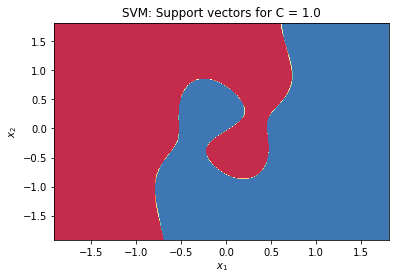

In [27]:
# adjust parameters
parameters = rbf_svc.get_params()
parameters['C'] = 1.0
svm = SVC(**parameters)
#----------------------------
# fit model
svm.fit(training_X, training_y)
plot_decision_regions(X, svm)
plt.title('SVM: Support vectors for C = 1.0')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig(path + 'decision_region_C_1.png', dpi=300)

In [28]:
print('Score =', svm.score(Xt, yt))

Score = 0.877


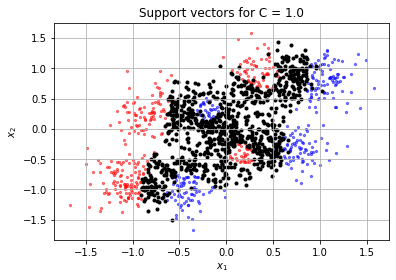

In [29]:
find_sv(X, y, svm)
plt.title('Support vectors for C = 1.0')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig(path + 'support_vectors_C_1.png', dpi=300)

## C = 20

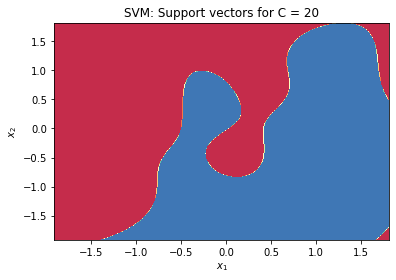

In [30]:
# adjust parameters
parameters = rbf_svc.get_params()
parameters['C'] = 20.0
svm = SVC(**parameters)
#----------------------------
# fit model
svm.fit(training_X, training_y)
plot_decision_regions(X, svm)
plt.title('SVM: Support vectors for C = 20')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig(path + 'decision_region_C_20.png', dpi=300)

In [31]:
print('Score =', svm.score(Xt, yt))

Score = 0.878


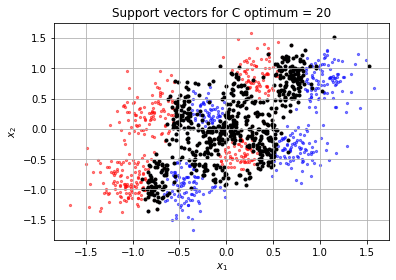

In [32]:
find_sv(X, y, svm)
plt.title('Support vectors for C optimum = 20')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig(path + 'support_vectors_C_20.png', dpi=300)

## C = 1000

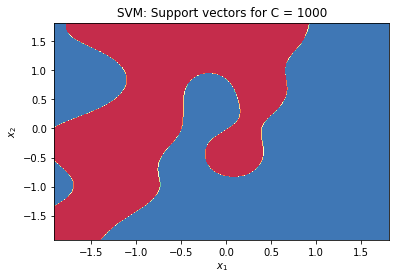

In [33]:
# adjust parameters
parameters = rbf_svc.get_params()
parameters['C'] = 1000.0
svm = SVC(**parameters)
#----------------------------
# fit model
svm.fit(training_X, training_y)
plot_decision_regions(X, svm)
plt.title('SVM: Support vectors for C = 1000')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig(path + 'decision_region_C_1000.png', dpi=300)

In [34]:
print('Score =', svm.score(Xt, yt))

Score = 0.88


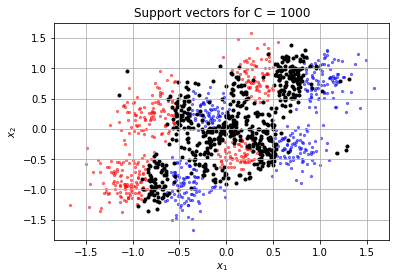

In [35]:
find_sv(X, y, svm)
plt.title('Support vectors for C = 1000')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig(path + 'support_vectors_C_1000.png', dpi=300)

# Exploring different gamma

## gamma = 0.1

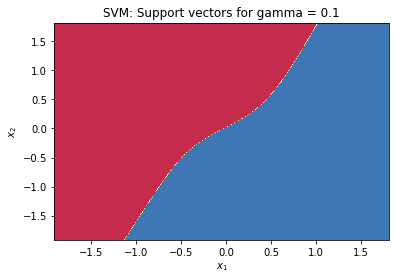

In [36]:
# adjust parameters
parameters = rbf_svc.get_params()
parameters['C'] = best_C
parameters['gamma'] = 0.1
svm = SVC(**parameters)
#----------------------------
# fit model
svm.fit(training_X, training_y)
plot_decision_regions(X, svm)
plt.title('SVM: Support vectors for gamma = 0.1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig(path + 'decision_region_gamma_0d1.png', dpi=300)

In [37]:
print('Score =', svm.score(Xt, yt))

Score = 0.718


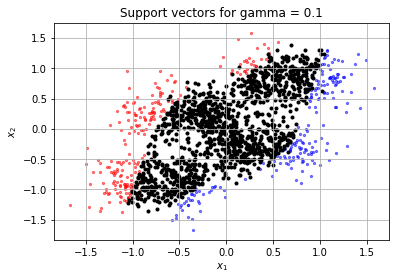

In [38]:
find_sv(X, y, svm)
plt.title('Support vectors for gamma = 0.1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig(path + 'support_vectors_gamma_0d1.png', dpi=300)

## gamma = 1.0

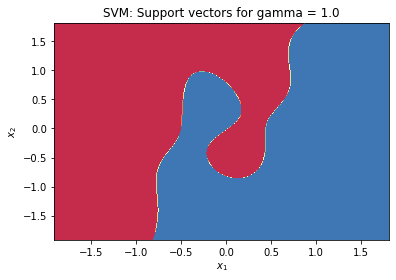

In [39]:
# adjust parameters
parameters = rbf_svc.get_params()
parameters['C'] = best_C
parameters['gamma'] = 1.0
svm = SVC(**parameters)
#----------------------------
# fit model
svm.fit(training_X, training_y)
plot_decision_regions(X, svm)
plt.title('SVM: Support vectors for gamma = 1.0')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig(path + 'decision_region_gamma_1.png', dpi=300)

In [40]:
print('Score =', svm.score(Xt, yt))

Score = 0.878


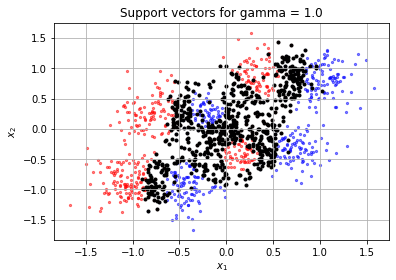

In [41]:
find_sv(X, y, svm)
plt.title('Support vectors for gamma = 1.0')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig(path + 'support_vectors_gamma_1.png', dpi=300)

## gamma = 10

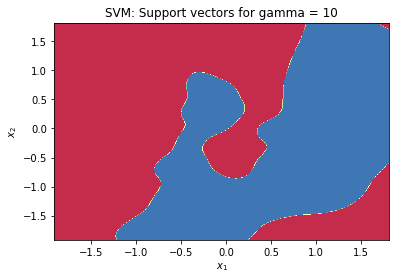

In [42]:
# adjust parameters
parameters = rbf_svc.get_params()
parameters['C'] = best_C
parameters['gamma'] = 10.0
svm = SVC(**parameters)
#----------------------------
# fit model
svm.fit(training_X, training_y)
plot_decision_regions(X, svm)
plt.title('SVM: Support vectors for gamma = 10')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig(path + 'decision_region_gamma_10.png', dpi=300)

In [43]:
print('Score =', svm.score(Xt, yt))

Score = 0.879


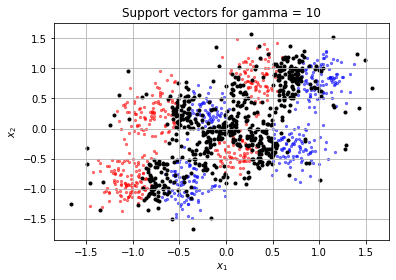

In [44]:
find_sv(X, y, svm)
plt.title('Support vectors for gamma = 10')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig(path + 'support_vectors_gamma_10.png', dpi=300)

# Exploring different kernels

... to be done ...